In [147]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

pd.set_option('float_format', '{:f}'.format)


%matplotlib inline

In [148]:
# Read the data and plot the first 5 columns
used_cars = pd.read_csv('autos.csv',encoding="ISO-8859-1")
used_cars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


# Exploring our data:
   in this section we will explore the data and checking the patterns on it.

In [149]:
# Looking at the std we can see how the data spreated 
# from our mean which mean there is an outlier in the price column

used_cars.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000
mean,17295.141865,2004.577997,115.549477,125618.688228,5.734445,0.000000,50820.667640
std,3587953.744411,92.866598,192.139578,40112.337051,3.712412,0.000000,25799.082470
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,0.000000,30459.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,49610.000000
75%,7200.000000,2008.000000,150.000000,150000.000000,9.000000,0.000000,71546.000000
max,2147483647.000000,9999.000000,20000.000000,150000.000000,12.000000,0.000000,99998.000000


In [150]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
dateCrawled            371528 non-null object
name                   371528 non-null object
seller                 371528 non-null object
offerType              371528 non-null object
price                  371528 non-null int64
abtest                 371528 non-null object
vehicleType            333659 non-null object
yearOfRegistration     371528 non-null int64
gearbox                351319 non-null object
powerPS                371528 non-null int64
model                  351044 non-null object
kilometer              371528 non-null int64
monthOfRegistration    371528 non-null int64
fuelType               338142 non-null object
brand                  371528 non-null object
notRepairedDamage      299468 non-null object
dateCreated            371528 non-null object
nrOfPictures           371528 non-null int64
postalCode             371528 non-null int64
lastSeen              

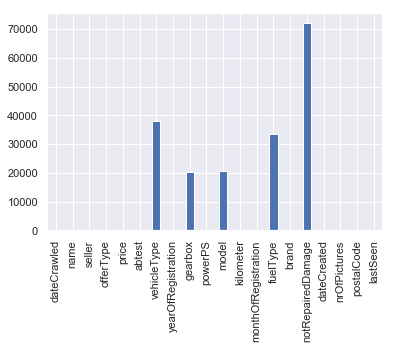

In [151]:
# Check for null values
used_cars.isnull().sum().plot.bar()

In [152]:
# Now lets check the null values in fuelType and compare it with the vehicleType
# to fill the null values.
used_cars.groupby('fuelType')['vehicleType'].value_counts()

fuelType  vehicleType
andere    limousine         51
          andere            44
          kleinwagen        29
          kombi             25
          bus               10
          suv                9
          cabrio             6
          coupe              3
benzin    kleinwagen     67739
          limousine      62245
          kombi          28012
          cabrio         19822
          coupe          15030
          bus             9742
          suv             4957
          andere          1428
cng       bus              240
          kombi            136
          kleinwagen        80
          limousine         40
          andere            14
          suv                4
          cabrio             3
          coupe              3
diesel    kombi          34848
          limousine      27648
          bus            18622
          suv             8665
          kleinwagen      6808
          coupe           2737
          cabrio          1871
          andere 

In [153]:
# we can see that vehicleType actually correspond to the fuelType 
# so let's fill them
vehicleType = used_cars['vehicleType'].unique()
fuelType = used_cars['fuelType'].unique()
vehicleType = np.delete(vehicleType,0)
# Remove nulls from the data
vehicleType = vehicleType[~pd.isnull(vehicleType)]
fuelType = fuelType[~pd.isnull(fuelType)]

print(vehicleType)
print(fuelType)

# Replace the nulls
d = {}
for i in fuelType :
    m = 0
    for j in vehicleType :
        if used_cars[(used_cars['vehicleType'] == j) & (used_cars['fuelType'] == i)].shape[0] > m :
            m = used_cars[(used_cars['vehicleType'] == j) & (used_cars['fuelType'] == i)].shape[0]
            d[i] = j


for i in fuelType :
    used_cars.loc[(used_cars['fuelType'] == i) & (used_cars['vehicleType'].isnull()) ,'vehicleType' ] = d[i]


used_cars.isnull().sum()

['coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
['benzin' 'diesel' 'lpg' 'andere' 'hybrid' 'cng' 'elektro']


dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            17495
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

# Dealing with Nulls
     Since we are creating a model that will predict the price of used cars 
     we will remove all null values from the data and check the amount of data that
     we will have at the end.

In [154]:
used_cars = used_cars.dropna()

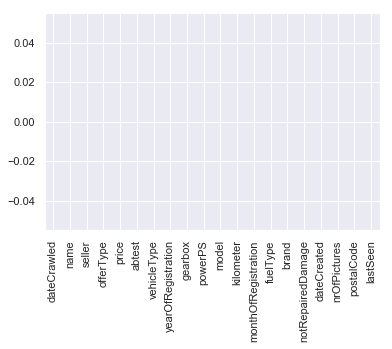

In [155]:
used_cars.isnull().sum().plot.bar()

In [156]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269135 entries, 3 to 371527
Data columns (total 20 columns):
dateCrawled            269135 non-null object
name                   269135 non-null object
seller                 269135 non-null object
offerType              269135 non-null object
price                  269135 non-null int64
abtest                 269135 non-null object
vehicleType            269135 non-null object
yearOfRegistration     269135 non-null int64
gearbox                269135 non-null object
powerPS                269135 non-null int64
model                  269135 non-null object
kilometer              269135 non-null int64
monthOfRegistration    269135 non-null int64
fuelType               269135 non-null object
brand                  269135 non-null object
notRepairedDamage      269135 non-null object
dateCreated            269135 non-null object
nrOfPictures           269135 non-null int64
postalCode             269135 non-null int64
lastSeen              

# Feature Engneering:
    for each column we have to deal with it individualy 
    
    - name: only represent the name of the car in this case we don't need it.
    

In [157]:
# unwanted columns ['name','postalCode','dateCrawled','dateCreated','lastSeen']

In [158]:
used_cars['name'].value_counts()

BMW_318i                                                   619
Volkswagen_Golf_1.4                                        582
BMW_316i                                                   516
BMW_320i                                                   491
Ford_Fiesta                                                433
Volkswagen_Polo                                            423
Opel_Corsa                                                 409
Volkswagen_Golf_1.6                                        406
Volkswagen_Polo_1.2                                        402
Volkswagen_Golf                                            400
BMW_116i                                                   392
Opel_Corsa_1.2_16V                                         355
Opel_Corsa_1.0_12V                                         330
Renault_Twingo_1.2                                         287
Volkswagen_Passat_Variant_1.9_TDI                          267
Volkswagen_Golf_1.9_TDI                                

In [159]:
# since only two values shows up as gewerblich we will drop that column.
used_cars['seller'].value_counts()

privat        269133
gewerblich         2
Name: seller, dtype: int64

In [160]:
used_cars['notRepairedDamage'].value_counts()

nein    239383
ja       29752
Name: notRepairedDamage, dtype: int64

In [161]:
used_cars['fuelType'].value_counts()

benzin     175204
diesel      89012
lpg          4071
cng           489
hybrid        223
andere         77
elektro        59
Name: fuelType, dtype: int64

# Detecting outliers:

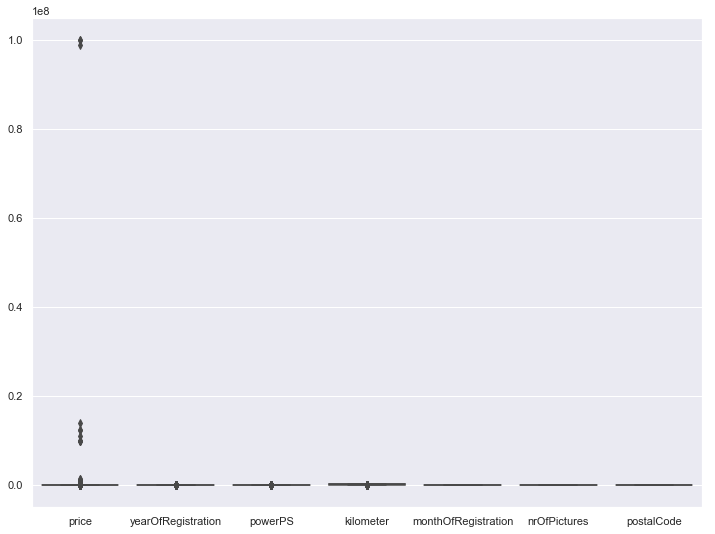

In [162]:
sns.set(rc={'figure.figsize':(12,9)})

sns.boxplot(data=used_cars)

In [163]:
# we can see that the min number of the pirce is 0 and it dose not make any sense 
# so we will remove any price with that range.
used_cars['price'].describe()

count     269135.000000
mean        8100.149698
std       338607.914969
min            0.000000
25%         1500.000000
50%         3750.000000
75%         8500.000000
max     99999999.000000
Name: price, dtype: float64

In [164]:
used_cars['price'].head()

3    1500
4    3600
5     650
6    2200
7       0
Name: price, dtype: int64

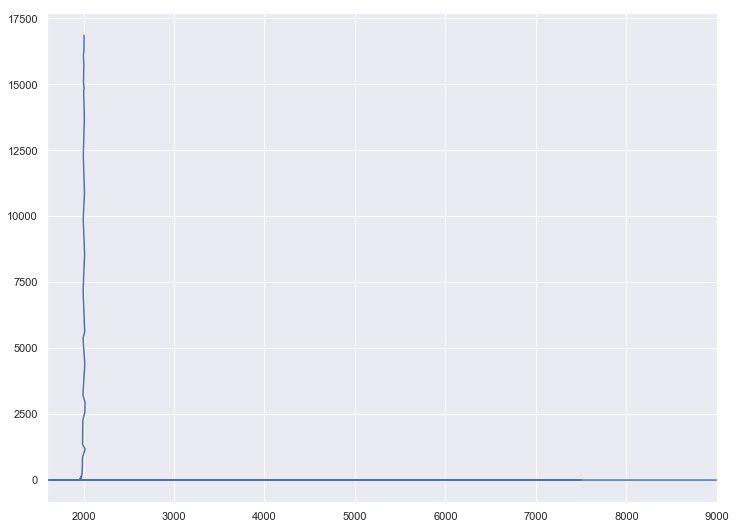

In [165]:
used_cars['yearOfRegistration'].value_counts().plot()

# We can see that there is more than 2018 date are there ! we will remove them.

In [166]:
used_cars[used_cars['yearOfRegistration'] < 1930]['yearOfRegistration'].value_counts()

1910    6
1923    2
1919    1
1929    1
1600    1
Name: yearOfRegistration, dtype: int64

In [167]:
used_cars['yearOfRegistration'].describe()


count   269135.000000
mean      2003.739436
std         24.108661
min       1600.000000
25%       1999.000000
50%       2004.000000
75%       2008.000000
max       9000.000000
Name: yearOfRegistration, dtype: float64

In [168]:
used_cars = used_cars[(used_cars['yearOfRegistration'] < 2018)  & (used_cars['yearOfRegistration'] > 1920)]

In [169]:
used_cars = used_cars[(used_cars['price'] > 1000) & (used_cars['price'] < 200000)]

In [170]:
used_cars.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,221305.000000,221305.000000,221305.000000,221305.000000,221305.000000,221305.000000,221305.000000
mean,7818.467066,2004.586426,133.910016,120914.891213,6.261869,0.000000,52329.256908
std,8907.816656,6.504942,146.305680,41157.481176,3.437072,0.000000,25784.564670
min,1001.000000,1923.000000,0.000000,5000.000000,0.000000,0.000000,1067.000000
25%,2500.000000,2001.000000,90.000000,90000.000000,3.000000,0.000000,31785.000000
50%,4990.000000,2005.000000,122.000000,150000.000000,6.000000,0.000000,51580.000000
75%,9950.000000,2009.000000,163.000000,150000.000000,9.000000,0.000000,73312.000000
max,199900.000000,2017.000000,20000.000000,150000.000000,12.000000,0.000000,99998.000000


In [171]:
# What is the Avarage price of used cars ?
# What kind of cars that people usually sells ?
# What is the relashionship between kilometer and the price of the car ?

In [172]:
# What is the Avarage price of used cars ?
used_cars['price'].describe()

count   221305.000000
mean      7818.467066
std       8907.816656
min       1001.000000
25%       2500.000000
50%       4990.000000
75%       9950.000000
max     199900.000000
Name: price, dtype: float64

In [173]:
# What kind of cars that people usually sells ?


In [174]:
# What is the relashionship between kilometer and the price of the car ?

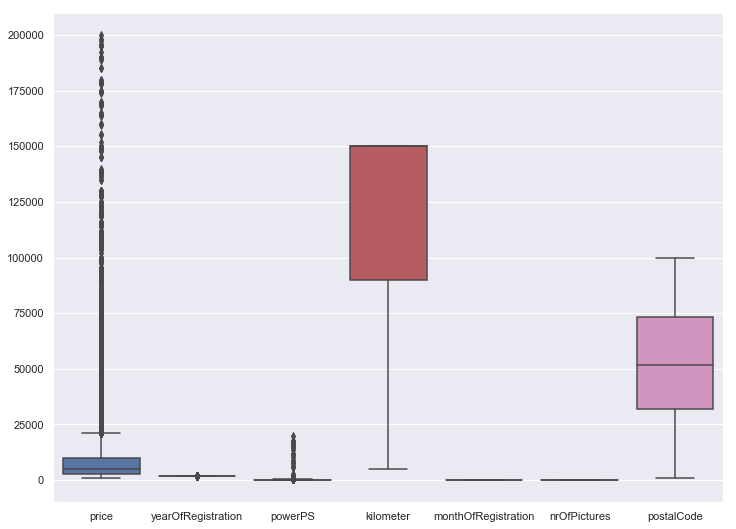

In [175]:
sns.set(rc={'figure.figsize':(12,9)})

sns.boxplot(data=used_cars)

In [176]:
used_cars.head()
# Remove = ['name','lastSeen','dateCreated','dateCrawled','postalCode']
# Dummy = ['seller','offerType','abtest','vehicleType','gearbox',
#        'model','fuelType','brand','notRepairedDamage']
# Predicted = ['price']

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,privat,Angebot,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
10,2016-03-26 19:54:18,Mazda_3_1.6_Sport,privat,Angebot,2000,control,limousine,2004,manuell,105,3_reihe,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,0,96224,2016-04-06 10:45:34
11,2016-04-07 10:06:22,Volkswagen_Passat_Variant_2.0_TDI_Comfortline,privat,Angebot,2799,control,kombi,2005,manuell,140,passat,150000,12,diesel,volkswagen,ja,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17


In [177]:
# function to clean the data.
def Clean_data(data):
    
    # Remove Unnecessary data
    data = data.drop(['name','lastSeen','dateCreated','dateCrawled','postalCode'],axis=1)
    
    # Remove yearOfRegistration < 2018 and > 1920 since it dose not make any sense:
    data = data[(data['yearOfRegistration'] < 2018)  & (data['yearOfRegistration'] > 1920)]
    data = data[(data['price'] > 1000) & (data['price'] < 200000)]

    # Retrive the data unique so we can compare it with the data in the dataframe.
    vehicleType = data['vehicleType'].unique()
    fuelType = data['fuelType'].unique()
    vehicleType = np.delete(vehicleType,0)
    # Remove nulls from the data
    vehicleType = vehicleType[~pd.isnull(vehicleType)]
    fuelType = fuelType[~pd.isnull(fuelType)]
    
    
    # Create for loop to replce the vehicle null value fuel Type with the right one compared to the vehicleType.
    d = {}
    for i in fuelType :
        m = 0
        for j in vehicleType :
            if data[(data['vehicleType'] == j) & (data['fuelType'] == i)].shape[0] > m :
                m = data[(data['vehicleType'] == j) & (data['fuelType'] == i)].shape[0]
                d[i] = j


    for i in fuelType :
        data.loc[(data['fuelType'] == i) & (data['vehicleType'].isnull()) ,'vehicleType' ] = d[i]    
    
    return data

In [178]:
# Function to prepare the data.
def prep_data(data):
    
    # Create Variables and predictor:
    Y  = data['price']
    X =  data.drop('price',axis=1)
    
    # Create dummy Variables:
    # First remove the Y value
    X =  used_cars.drop('price',axis=1)

    # convert the data into dummy
    dummy_data = pd.get_dummies(X[['seller','offerType','abtest','vehicleType','gearbox',\
                      'model','fuelType','brand','notRepairedDamage']])

    # Drop the Dummy data from the X
    X = X.drop(['seller','offerType','abtest','vehicleType','gearbox',\
                      'model','fuelType','brand','notRepairedDamage'],axis=1)

    X = pd.concat([X, dummy_data], axis=1) 

    return X,Y

In [179]:
# Now let's create the model:
# Here we will create list of models and preforme them all to the data to choose the best sloution.

# Function to compare the data
def compare_models(X,Y):

    # you can add any model you want.
    models = []
    models.append(('DecisionTreeRegressor', tree.DecisionTreeRegressor()))
    models.append(('GradientBoostingRegressor',GradientBoostingRegressor()))
    models.append(('RandomForestRegressor', RandomForestRegressor()))

    seed = 7

    names = []
    scores = []
    test_size = 0.33
    seed = 7
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
    # loop in models and store each socre in list to comapre them later
    for name,model in models:
        model.fit(X_train, Y_train)
        accuracy = model.score(X_test, Y_test)
        # Append the name of the model and its score.
        scores.append(accuracy)
        names.append(name)
        print(name, 'accuracy',accuracy)
        
    return names, scores

# Testing our result to the origenal data:

In [180]:
used_cars = pd.read_csv('autos.csv',encoding="ISO-8859-1")

In [181]:
used_cars = Clean_data(used_cars)
used_cars.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,nrOfPictures
1,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,0
2,privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,0
3,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,0
4,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,0
6,privat,Angebot,2200,test,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein,0


In [182]:
X,Y = prep_data(used_cars)
print(X.shape, Y.shape)

(280050, 321) (280050,)


In [183]:
names, scores = compare_models(X,Y)

DecisionTreeRegressor accuracy 0.6870134946723355
GradientBoostingRegressor accuracy 0.7677642639706639


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor accuracy 0.8221126623347216


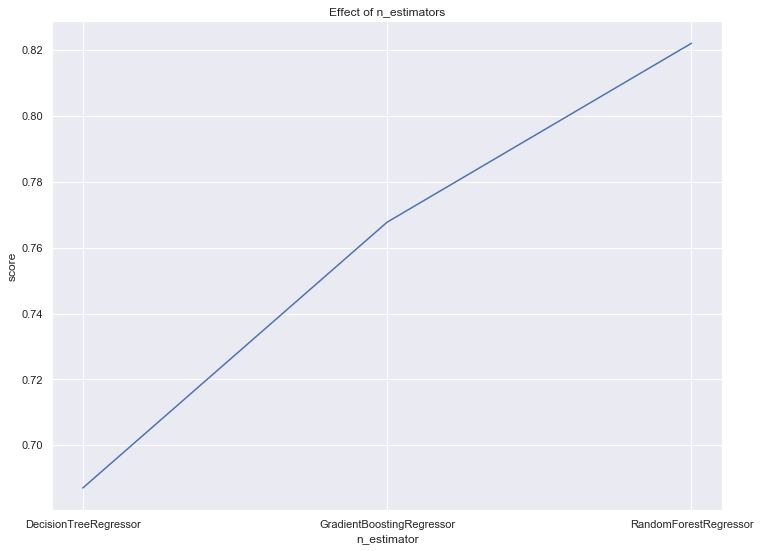

In [184]:
# Create Graph to compare models.
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(names, scores)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


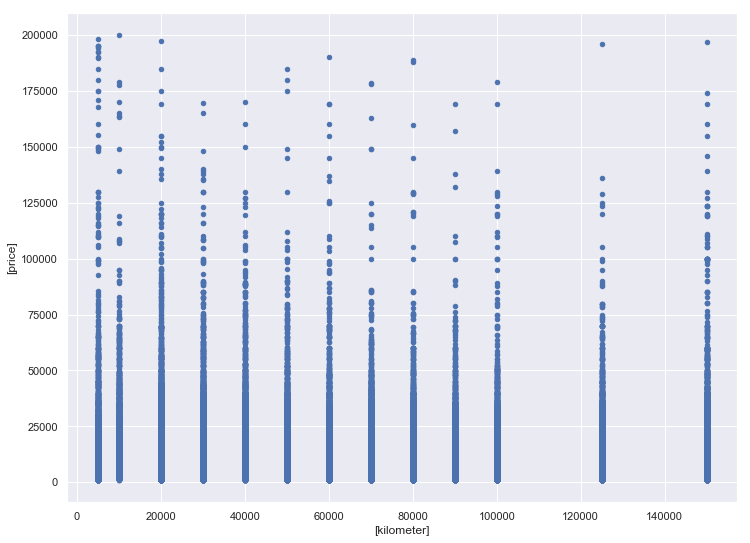

In [185]:
used_cars.plot.scatter(x=['kilometer'],y=['price'])

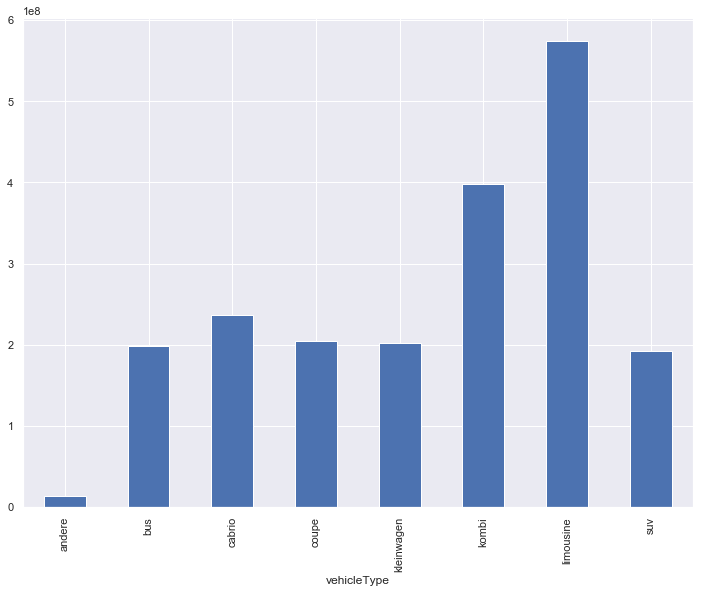

In [197]:

used_cars.groupby('vehicleType')['price'].sum().plot.bar()

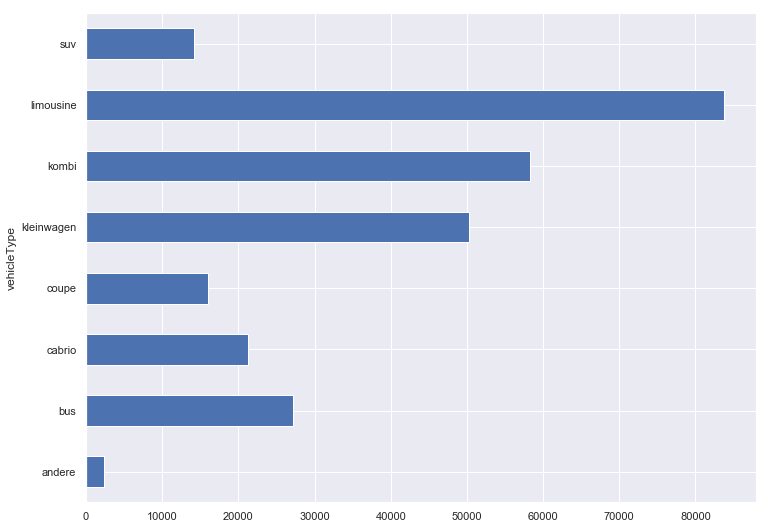

In [198]:
used_cars.groupby('vehicleType').seller.count().plot.barh()

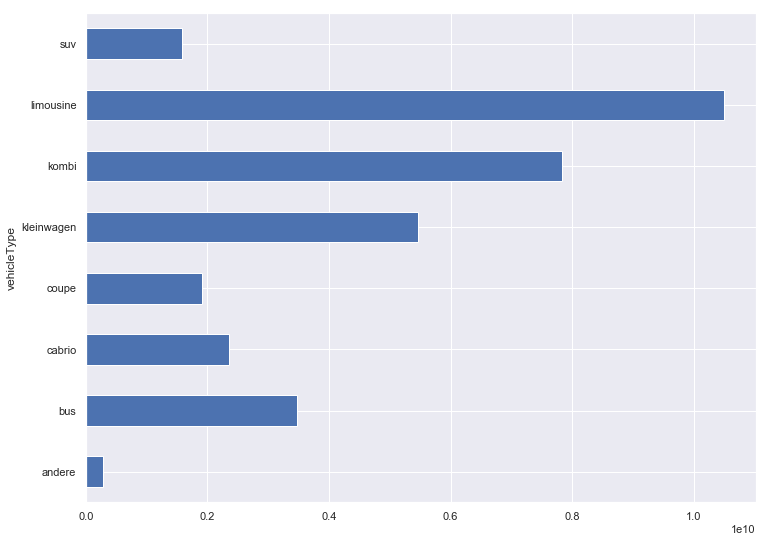

In [202]:
used_cars.groupby('vehicleType')['kilometer'].sum().plot.barh()

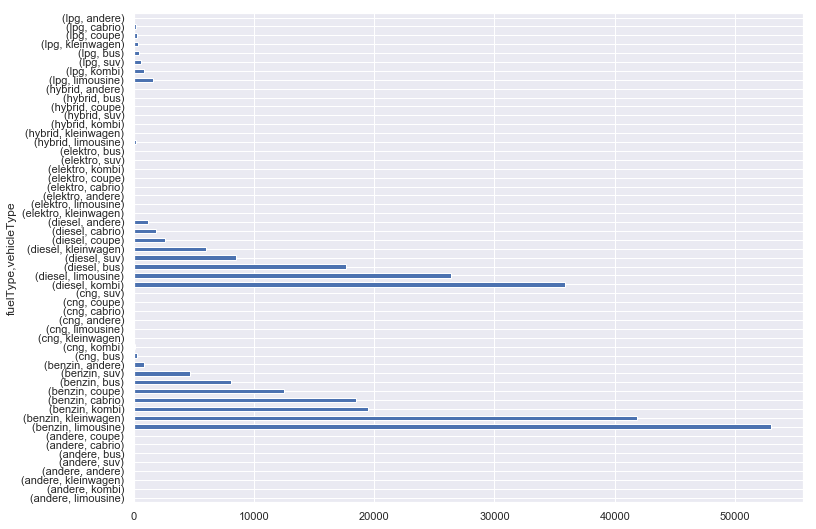

In [201]:
# What type of fuel for each vehicleType 
used_cars.groupby('fuelType')['vehicleType'].value_counts().plot.barh()

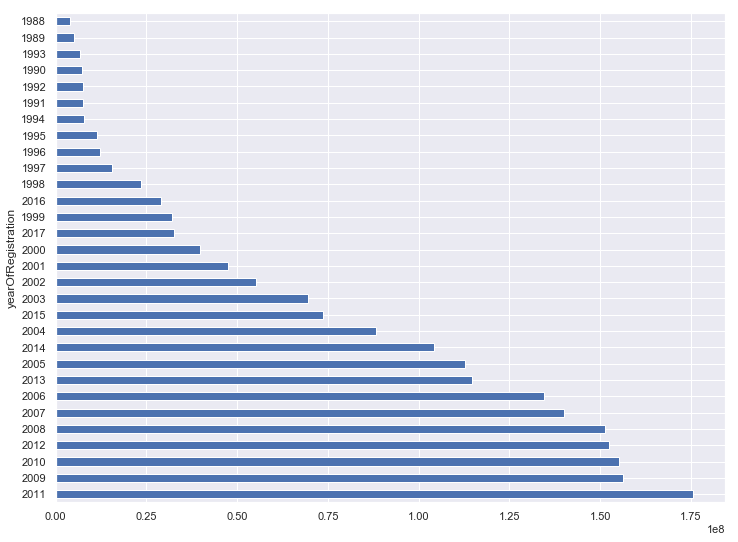

In [224]:


used_cars.groupby('yearOfRegistration')['price'].sum().sort_values(ascending=False).head(30).plot.barh()

In [225]:
used_cars.columns

Index(['seller', 'offerType', 'price', 'abtest', 'vehicleType',
       'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'nrOfPictures'],
      dtype='object')

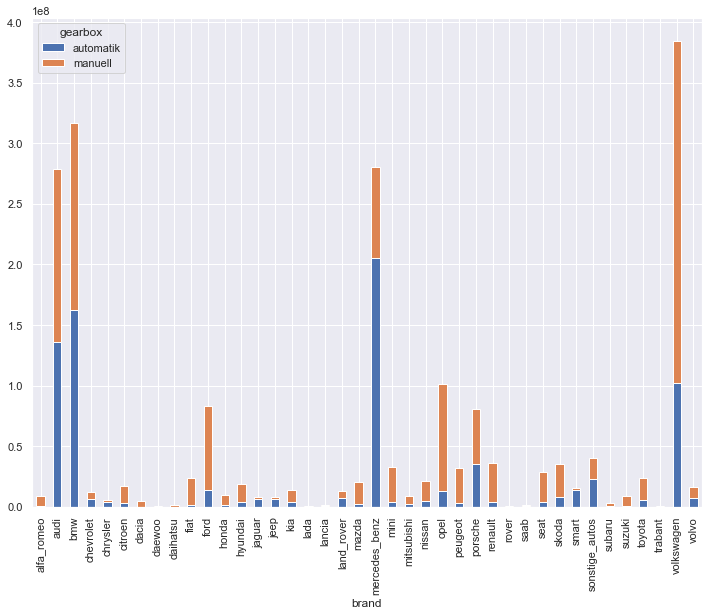

In [244]:

used_cars.groupby(['brand','gearbox'])['price'].sum().unstack().plot(kind='bar',stacked=True)